In [2]:
# Imports
!pip uninstall -y numpy
!pip install numpy==1.25.2

Found existing installation: numpy 1.25.2
Uninstalling numpy-1.25.2:
  Successfully uninstalled numpy-1.25.2
  Using cached numpy-1.25.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
Using cached numpy-1.25.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.25.2 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.25.2 which is incompatible.
blosc2 3.3.1 requires numpy>=1.26, but you have numpy 1.25.2 which is incompatible.


In [3]:
!pip install datasets==2.20.0 pandas==2.2.2 pyarrow==15.0.2

ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
^C


In [9]:
!pip install datasets==2.20.0 pandas==2.2.2 pyarrow==15.0.2 transformers==4.34.1 evaluate==0.4.1 librosa==0.10.2 numpy==1.25.2 audiomentations==2.0.4
import os
import shutil
import time
import re
import librosa
import numpy as np
from pydub import AudioSegment
from datasets import load_dataset
from transformers import (
    AutoModelForAudioClassification,
    TrainingArguments,
    Trainer,
    Wav2Vec2Processor,
    Wav2Vec2CTCTokenizer,
)
from audiomentations import Compose, AddGaussianNoise, PitchShift, TimeStretch, Gain
import evaluate
from google.colab import files

# Clear disk space and Hugging Face cache
def clear_disk_and_cache():
    print("Clearing disk space and Hugging Face cache...")
    shutil.rmtree("/root/.cache/huggingface", ignore_errors=True)
    shutil.rmtree("/content/results", ignore_errors=True)
    shutil.rmtree("/content/logs", ignore_errors=True)
    for d in os.listdir("/content"):
        if d.startswith("facebook") or "wav2vec2" in d:
            shutil.rmtree(os.path.join("/content", d), ignore_errors=True)
    print("Disk and cache cleared.")

# Clear previous files
def clear_workspace():
    print("Clearing workspace...")
    shutil.rmtree("/content/LL_final_project", ignore_errors=True)
    shutil.rmtree("/content/data", ignore_errors=True)
    for f in os.listdir("/content"):
        if f.endswith(".m4a"):
            os.remove(os.path.join("/content", f))
    print("Workspace cleared.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.5/121.5 kB 11.3 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement audiomentations==2.0.4 (from versions: 0.1.0, 0.2.0, 0.3.0, 0.4.0, 0.5.0, 0.6.0, 0.7.0, 0.8.0, 0.9.0, 0.10.0, 0.10.1, 0.11.0, 0.12.0, 0.12.1, 0.13.0, 0.14.0, 0.15.0, 0.16.0, 0.17.0, 0.18.0, 0.19.0, 0.20.0, 0.21.0, 0.22.0, 0.23.0, 0.24.0, 0.25.0, 0.25.1, 0.26.0, 0.27.0, 0.28.0, 0.29.0, 0.30.0, 0.31.0, 0.32.0, 0.33.0, 0.34.1, 0.35.0, 0.36.0, 0.36.1, 0.37.0, 0.38.0, 0.39.0, 0.40.0)
ERROR: No matching distribution found for audiomentations==2.0.4


In [1]:
# Step 1: Upload and organize M4A files
def organize_m4a_files(m4a_dir):
    print("Creating flat directory...")
    os.makedirs(m4a_dir, exist_ok=True)
    print(f"Created directory: {m4a_dir}")
    if not os.path.exists(m4a_dir):
        print(f"Error: Failed to create {m4a_dir}")
        return False, []

    clear_workspace()
    print("Uploading files (select all 70 files, or upload in batches if prompted)...")
    uploaded = files.upload()
    print(f"Uploaded {len(uploaded)} files in first batch.")

    valid_files = []
    for filename in uploaded.keys():
        content_path = os.path.join("/content", filename)
        try:
            with open(content_path, "wb") as f:
                f.write(uploaded[filename])
            try:
                with open(content_path, "rb") as f:
                    f.read(1)
                print(f"Saved and readable: {filename}")
                valid_files.append(filename)
            except Exception as e:
                print(f"Warning: Cannot read {filename}: {e}")
        except Exception as e:
            print(f"Warning: Failed to save {filename}: {e}")

    while len(valid_files) < 70:
        print(f"Only {len(valid_files)} files uploaded. Need {70 - len(valid_files)} more.")
        response = input("Upload more files? (yes/no): ").strip().lower()
        if response != "yes":
            print("Proceeding with available files...")
            break
        print("Uploading additional batch...")
        uploaded = files.upload()
        print(f"Uploaded {len(uploaded)} files in additional batch.")
        for filename in uploaded.keys():
            content_path = os.path.join("/content", filename)
            try:
                with open(content_path, "wb") as f:
                    f.write(uploaded[filename])
                try:
                    with open(content_path, "rb") as f:
                        f.read(1)
                    print(f"Saved and readable: {filename}")
                    if filename not in valid_files:
                        valid_files.append(filename)
                except Exception as e:
                    print(f"Warning: Cannot read {filename}: {e}")
            except Exception as e:
                print(f"Warning: Failed to save {filename}: {e}")

    time.sleep(10)  # Delay for filesystem sync

    print(f"Total valid files in /content/: {len(valid_files)}")
    print("Files in /content/:")
    !ls -l /content/ | grep ".m4a"

    copied_files = []
    for filename in valid_files:
        content_path = os.path.join("/content", filename)
        dest_path = os.path.join(m4a_dir, filename)
        if not os.path.exists(content_path):
            print(f"Warning: Source file missing: {filename}")
            continue
        if os.path.exists(dest_path):
            print(f"Warning: Destination file exists: {dest_path}")
            copied_files.append(filename)
            continue
        print(f"Moving {filename} to {dest_path}")
        try:
            shutil.move(content_path, dest_path)
            print(f"Successfully moved {filename}")
            copied_files.append(filename)
        except Exception as e:
            print(f"Warning: Error moving {filename}: {e}")
            time.sleep(1)
            try:
                shutil.move(content_path, dest_path)
                print(f"Successfully moved {filename} on retry")
                copied_files.append(filename)
            except Exception as e:
                print(f"Skipping {filename} after retry: {e}")

    if not copied_files:
        print("No files moved. Using files in /content/ for conversion...")
        copied_files = valid_files.copy()

    print(f"Total files in {m4a_dir}: {len(copied_files)}")
    print("Verifying file structure:")
    !ls -l {m4a_dir}/* 2>/dev/null || echo "No files in directory"
    !ls -l /content/ | grep ".m4a" || echo "No .m4a files left in /content/"

    file_numbers = []
    for f in copied_files:
        match = re.match(r"New Recording (\d+)\.m4a", f)
        if match:
            file_numbers.append(int(match.group(1)))
        else:
            print(f"Skipping invalid file: {f}")

    expected_numbers = list(range(1, 71))
    if len(file_numbers) < 35:
        print(f"Warning: Too few files. Expected at least 35, got {len(file_numbers)}.")
        print("Detected file numbers:", sorted(file_numbers))
        print("Proceeding anyway...")
    if len(file_numbers) != 70:
        missing = sorted(set(expected_numbers) - set(file_numbers))
        extra = sorted(set(file_numbers) - set(expected_numbers))
        print(f"Warning: Expected 70 files, got {len(file_numbers)}.")
        print("Detected file numbers:", sorted(file_numbers))
        if missing:
            print("Missing files:", [f"New Recording {n}.m4a" for n in missing])
        if extra:
            print("Extra files:", [f"New Recording {n}.m4a" for n in extra])
        print("Continuing with available files...")

    return True, copied_files

In [2]:
# Step 2: Convert M4A to WAV + validate audio
def convert_m4a_to_wav(m4a_dir, data_dir, copied_files):
    print(f"Converting files and validating audio...")
    commands = ["startrecipe", "nextstep", "repeatstep", "timer", "substitute", "scale", "done"]
    command_counters = {cmd: 0 for cmd in commands}

    for filename in sorted(copied_files):
        if filename.endswith(".m4a"):
            match = re.match(r"New Recording (\d+)\.m4a", filename)
            if match:
                num = int(match.group(1))
                if 1 <= num <= 10:
                    cmd = "startrecipe"
                elif 11 <= num <= 20:
                    cmd = "nextstep"
                elif 21 <= num <= 30:
                    cmd = "repeatstep"
                elif 31 <= num <= 40:
                    cmd = "timer"
                elif 41 <= num <= 50:
                    cmd = "substitute"
                elif 51 <= num <= 60:
                    cmd = "scale"
                else:  # 61-70
                    cmd = "done"

                command_dir = os.path.join(data_dir, cmd)
                os.makedirs(command_dir, exist_ok=True)
                command_counters[cmd] += 1
                wav_filename = f"{cmd}_{command_counters[cmd]:02d}.wav"
                m4a_path = os.path.join(m4a_dir, filename)
                if not os.path.exists(m4a_path):
                    m4a_path = os.path.join("/content", filename)
                if not os.path.exists(m4a_path):
                    print(f"Warning: File missing: {filename}")
                    continue
                wav_path = os.path.join(command_dir, wav_filename)

                try:
                    audio = AudioSegment.from_file(m4a_path, format="m4a")
                    audio = audio.set_frame_rate(16000).set_channels(1)  # Mono, 16kHz
                    audio.export(wav_path, format="wav")
                    print(f"Converted {filename} to {wav_filename}")

                    # Validate audio
                    y, sr = librosa.load(wav_path, sr=16000)
                    if len(y) == 0 or np.max(np.abs(y)) < 1e-4:
                        print(f"Warning: {wav_filename} is silent or nearly silent.")
                    else:
                        print(f"Validated {wav_filename}: Duration={len(y)/sr:.2f}s, Max amplitude={np.max(np.abs(y)):.4f}")
                except Exception as e:
                    print(f"Warning: Failed to convert or validate {filename}: {e}")

In [3]:
# Step 3: Load dataset
def load_audio_dataset(data_dir):
    try:
        dataset = load_dataset("audiofolder", data_dir=data_dir)
        print("Dataset loaded successfully.")
        # integer labels
        label_map = {
            "startrecipe": 0,
            "nextstep": 1,
            "repeatstep": 2,
            "timer": 3,
            "substitute": 4,
            "scale": 5,
            "done": 6
        }
        def assign_labels(example):
            folder_name = os.path.basename(os.path.dirname(example["audio"]["path"]))
            example["label"] = label_map[folder_name]
            return example
        dataset = dataset.map(assign_labels)
        print("Labels assigned:", set(dataset["train"]["label"]))
        return dataset
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None

In [4]:
# Step 4: Preprocess audio data
def preprocess_audio(dataset):
    try:
        processor = Wav2Vec2Processor.from_pretrained(
            "facebook/wav2vec2-base",
            tokenizer_class="Wav2Vec2CTCTokenizer"
        )
        feature_extractor = processor.feature_extractor
    except Exception as e:
        print(f"Error loading processor: {e}")
        return None

    augment = Compose([
        AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.02, p=0.5),
        PitchShift(min_semitones=-2, max_semitones=2, p=0.5),
        TimeStretch(min_rate=0.8, max_rate=1.2, p=0.5),
        Gain(min_gain_db=-6, max_gain_db=6, p=0.5)
    ])

    def preprocess_function(examples):
        audio_arrays = [x["array"] for x in examples["audio"]]
        # Normalize audio
        audio_arrays = [x / np.max(np.abs(x)) if np.max(np.abs(x)) > 0 else x for x in audio_arrays]
        # Apply augmentations
        augmented_arrays = [augment(samples=x, sample_rate=16000) for x in audio_arrays]
        inputs = feature_extractor(
            augmented_arrays,
            sampling_rate=16000,
            max_length=16000,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        inputs["labels"] = examples["label"]
        return inputs

    encoded_dataset = dataset.map(preprocess_function, remove_columns=["audio"], batched=True)
    return encoded_dataset

In [5]:
# Step 5: Load the model
def load_model():
    model = AutoModelForAudioClassification.from_pretrained(
        "facebook/wav2vec2-base",
        num_labels=7,
        label2id={
            "startrecipe": 0,
            "nextstep": 1,
            "repeatstep": 2,
            "timer": 3,
            "substitute": 4,
            "scale": 5,
            "done": 6
        },
        id2label={str(i): label for i, label in enumerate(["startrecipe", "nextstep", "repeatstep", "timer", "substitute", "scale", "done"])}
    )
    model.classifier.dropout = torch.nn.Dropout(0.3)
    return model

In [6]:
# Step 6: Define evaluation metrics
def compute_metrics(eval_pred):
    accuracy_metric = evaluate.load("accuracy")
    f1_metric = evaluate.load("f1")
    precision_metric = evaluate.load("precision")
    recall_metric = evaluate.load("recall")

    predictions = np.argmax(eval_pred.predictions, axis=1)
    labels = eval_pred.label_ids

    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")
    precision = precision_metric.compute(predictions=predictions, references=labels, average="weighted")
    recall = recall_metric.compute(predictions=predictions, references=labels, average="weighted")

    return {
        "accuracy": accuracy["accuracy"],
        "f1": f1["f1"],
        "precision": precision["precision"],
        "recall": recall["recall"]
    }

In [11]:
# Step 7: Train + evaluate with k-fold cross-validation
import torch
def train_model(encoded_dataset):
    dataset = encoded_dataset["train"]
    from sklearn.model_selection import StratifiedKFold
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    labels = [dataset[i]["label"] for i in range(len(dataset))]

    fold_results = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(range(len(dataset)), labels)):
        print(f"\nTraining fold {fold + 1}/5...")
        train_dataset = dataset.select(train_idx)
        val_dataset = dataset.select(val_idx)

        training_args = TrainingArguments(
            output_dir=f"./results/fold_{fold}",
            num_train_epochs=20,
            per_device_train_batch_size=4,
            per_device_eval_batch_size=4,
            eval_strategy="epoch",
            save_strategy="no",
            logging_steps=5,
            learning_rate=5e-5,
            lr_scheduler_type="cosine",
            load_best_model_at_end=False,
            metric_for_best_model="accuracy",
            logging_dir=f"./logs/fold_{fold}",
            weight_decay=0.01,
            gradient_accumulation_steps=2,
            label_smoothing_factor=0.1,
            max_grad_norm=1.0
        )

        trainer = Trainer(
            model=load_model(),
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=compute_metrics
        )

        try:
            trainer.train()
        except Exception as e:
            print(f"Warning: Training failed in fold {fold + 1}: {e}")
            continue

        eval_results = trainer.evaluate()
        print(f"Fold {fold + 1} evaluation results:", eval_results)
        fold_results.append(eval_results)

    if fold_results:
        avg_results = {
            "eval_accuracy": np.mean([r["eval_accuracy"] for r in fold_results]),
            "eval_f1": np.mean([r["eval_f1"] for r in fold_results]),
            "eval_precision": np.mean([r["eval_precision"] for r in fold_results]),
            "eval_recall": np.mean([r["eval_recall"] for r in fold_results])
        }
        print("Average cross-validation results:", avg_results)
    else:
        print("No folds completed successfully.")

    return trainer

# Main function
def main():
    clear_disk_and_cache()

    m4a_dir = "/content/LL_final_project"
    data_dir = "/content/data"

    success, copied_files = organize_m4a_files(m4a_dir)
    if not copied_files:
        print("No files available. Cannot proceed.")
        return None

    convert_m4a_to_wav(m4a_dir, data_dir, copied_files)
    dataset = load_audio_dataset(data_dir)
    if dataset is None:
        return None
    encoded_dataset = preprocess_audio(dataset)
    if encoded_dataset is None:
        return None
    trainer = train_model(encoded_dataset)
    return trainer

if __name__ == "__main__":
    main()

Clearing disk space and Hugging Face cache...
Disk and cache cleared.
Creating flat directory...
Created directory: /content/LL_final_project
Clearing workspace...
Workspace cleared.
Uploading files (select all 70 files, or upload in batches if prompted)...


Saving New Recording 70.m4a to New Recording 70.m4a
Saving New Recording 69.m4a to New Recording 69.m4a
Saving New Recording 68.m4a to New Recording 68.m4a
Saving New Recording 67.m4a to New Recording 67.m4a
Saving New Recording 66.m4a to New Recording 66.m4a
Saving New Recording 65.m4a to New Recording 65.m4a
Saving New Recording 64.m4a to New Recording 64.m4a
Saving New Recording 63.m4a to New Recording 63.m4a
Saving New Recording 62.m4a to New Recording 62.m4a
Saving New Recording 61.m4a to New Recording 61.m4a
Saving New Recording 60.m4a to New Recording 60.m4a
Saving New Recording 59.m4a to New Recording 59.m4a
Saving New Recording 58.m4a to New Recording 58.m4a
Saving New Recording 57.m4a to New Recording 57.m4a
Saving New Recording 56.m4a to New Recording 56.m4a
Saving New Recording 55.m4a to New Recording 55.m4a
Saving New Recording 54.m4a to New Recording 54.m4a
Saving New Recording 53.m4a to New Recording 53.m4a
Saving New Recording 52.m4a to New Recording 52.m4a
Saving New R

Resolving data files:   0%|          | 0/70 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset loaded successfully.


Map:   0%|          | 0/70 [00:00<?, ? examples/s]

Labels assigned: {0, 1, 2, 3, 4, 5, 6}


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

Map:   0%|          | 0/70 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/audiomentations/core/transforms_interface.py:108: UserWarning: Warning: input samples dtype is np.float64. Converting to np.float32
  warnings.warn(



Training fold 1/5...


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/380M [00:00<?, ?B/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: rim1d (rim1d-lighthouse-labs) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.950000,1.950352,0.142857,0.035714,0.020408,0.142857
2,1.961400,1.955493,0.142857,0.035714,0.020408,0.142857
3,1.949700,1.949164,0.142857,0.035714,0.020408,0.142857
4,1.958300,1.946956,0.142857,0.035714,0.020408,0.142857
5,1.957700,1.946591,0.142857,0.035714,0.020408,0.142857
6,1.949800,1.946142,0.142857,0.035714,0.020408,0.142857
7,1.947500,1.946225,0.142857,0.035714,0.020408,0.142857
8,1.947000,1.946371,0.142857,0.035714,0.020408,0.142857
9,1.948000,1.946300,0.142857,0.035714,0.020408,0.142857
10,1.949300,1.946376,0.142857,0.063492,0.040816,0.142857


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 1 evaluation results: {'eval_loss': 1.9459993839263916, 'eval_accuracy': 0.14285714285714285, 'eval_f1': 0.03571428571428571, 'eval_precision': 0.02040816326530612, 'eval_recall': 0.14285714285714285, 'eval_runtime': 4.9942, 'eval_samples_per_second': 2.803, 'eval_steps_per_second': 0.801, 'epoch': 20.0}

Training fold 2/5...


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.959200,1.945757,0.142857,0.035714,0.020408,0.142857
2,1.945800,1.916661,0.357143,0.238095,0.190476,0.357143
3,1.886600,1.950937,0.285714,0.190476,0.154762,0.285714
4,1.915300,1.950435,0.142857,0.142857,0.142857,0.142857
5,1.904600,1.938226,0.214286,0.130952,0.095238,0.214286
6,1.853700,1.912806,0.285714,0.170068,0.121429,0.285714
7,1.838400,1.881396,0.285714,0.170068,0.121429,0.285714
8,1.788000,1.869368,0.357143,0.319048,0.333333,0.357143
9,1.719400,1.835804,0.428571,0.319048,0.309524,0.428571
10,1.651500,1.792142,0.357143,0.290043,0.317460,0.357143


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 2 evaluation results: {'eval_loss': 1.5667154788970947, 'eval_accuracy': 0.7857142857142857, 'eval_f1': 0.7333333333333334, 'eval_precision': 0.738095238095238, 'eval_recall': 0.7857142857142857, 'eval_runtime': 5.0091, 'eval_samples_per_second': 2.795, 'eval_steps_per_second': 0.799, 'epoch': 20.0}

Training fold 3/5...


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.959100,1.949688,0.142857,0.038095,0.021978,0.142857
2,1.942700,1.962910,0.071429,0.035714,0.023810,0.071429
3,1.923500,1.971843,0.142857,0.095238,0.085714,0.142857
4,1.890100,1.973063,0.071429,0.028571,0.017857,0.071429
5,1.881300,1.976205,0.071429,0.023810,0.014286,0.071429
6,1.860500,1.978361,0.071429,0.023810,0.014286,0.071429
7,1.831300,1.918796,0.142857,0.047619,0.028571,0.142857
8,1.828100,1.851346,0.214286,0.099567,0.067460,0.214286
9,1.744500,1.872599,0.214286,0.167800,0.191837,0.214286
10,1.769500,1.925319,0.285714,0.246032,0.270408,0.285714


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Fold 3 evaluation results: {'eval_loss': 1.7685987949371338, 'eval_accuracy': 0.42857142857142855, 'eval_f1': 0.41428571428571426, 'eval_precision': 0.4404761904761904, 'eval_recall': 0.42857142857142855, 'eval_runtime': 4.9585, 'eval_samples_per_second': 2.823, 'eval_steps_per_second': 0.807, 'epoch': 20.0}

Training fold 4/5...


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.957500,1.928723,0.214286,0.133333,0.164835,0.214286
2,1.954400,1.881742,0.214286,0.128571,0.095238,0.214286
3,1.911000,1.899259,0.357143,0.223810,0.178571,0.357143
4,1.915500,1.912391,0.142857,0.166667,0.214286,0.142857
5,1.875600,1.826115,0.285714,0.200000,0.166667,0.285714
6,1.881900,1.887595,0.142857,0.152381,0.190476,0.142857
7,1.813100,1.909804,0.285714,0.302721,0.385714,0.285714
8,1.801700,1.917394,0.357143,0.338095,0.357143,0.357143
9,1.789000,1.715571,0.642857,0.600680,0.652381,0.642857
10,1.737400,1.686560,0.500000,0.371429,0.297619,0.500000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 4 evaluation results: {'eval_loss': 1.5002623796463013, 'eval_accuracy': 0.5714285714285714, 'eval_f1': 0.5142857142857143, 'eval_precision': 0.5119047619047619, 'eval_recall': 0.5714285714285714, 'eval_runtime': 5.1482, 'eval_samples_per_second': 2.719, 'eval_steps_per_second': 0.777, 'epoch': 20.0}

Training fold 5/5...


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.953000,1.960502,0.214286,0.101099,0.073593,0.214286
2,1.965300,1.948617,0.142857,0.047619,0.028571,0.142857
3,1.972000,1.950181,0.142857,0.035714,0.020408,0.142857
4,1.950900,1.952741,0.142857,0.035714,0.020408,0.142857
5,1.970300,1.948600,0.142857,0.035714,0.020408,0.142857
6,1.953400,1.947278,0.142857,0.035714,0.020408,0.142857
7,1.949500,1.947125,0.142857,0.035714,0.020408,0.142857
8,1.947500,1.947019,0.142857,0.035714,0.020408,0.142857
9,1.949300,1.946697,0.142857,0.035714,0.020408,0.142857
10,1.951100,1.946793,0.142857,0.035714,0.020408,0.142857


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Fold 5 evaluation results: {'eval_loss': 1.9434731006622314, 'eval_accuracy': 0.14285714285714285, 'eval_f1': 0.05194805194805195, 'eval_precision': 0.031746031746031744, 'eval_recall': 0.14285714285714285, 'eval_runtime': 5.4105, 'eval_samples_per_second': 2.588, 'eval_steps_per_second': 0.739, 'epoch': 20.0}
Average cross-validation results: {'eval_accuracy': 0.4142857142857143, 'eval_f1': 0.34991341991341995, 'eval_precision': 0.34852607709750566, 'eval_recall': 0.4142857142857143}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [12]:
!zip -r /content/data.zip /content/data/
from google.colab import files
files.download("/content/data.zip")

  adding: content/data/ (stored 0%)
  adding: content/data/nextstep/ (stored 0%)
  adding: content/data/nextstep/nextstep_08.wav (deflated 37%)
  adding: content/data/nextstep/nextstep_01.wav (deflated 30%)
  adding: content/data/nextstep/nextstep_06.wav (deflated 34%)
  adding: content/data/nextstep/nextstep_03.wav (deflated 29%)
  adding: content/data/nextstep/nextstep_10.wav (deflated 35%)
  adding: content/data/nextstep/nextstep_07.wav (deflated 28%)
  adding: content/data/nextstep/nextstep_09.wav (deflated 28%)
  adding: content/data/nextstep/nextstep_02.wav (deflated 23%)
  adding: content/data/nextstep/nextstep_04.wav (deflated 23%)
  adding: content/data/nextstep/nextstep_05.wav (deflated 29%)
  adding: content/data/startrecipe/ (stored 0%)
  adding: content/data/startrecipe/startrecipe_08.wav (deflated 25%)
  adding: content/data/startrecipe/startrecipe_09.wav (deflated 27%)
  adding: content/data/startrecipe/startrecipe_03.wav (deflated 36%)
  adding: content/data/startrecipe

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Research and analysis: EDA

1. Audio Metadata Analysis
- Goal: Summarize audio properties (duration, sample rate, class distribution).

In [14]:
from datasets import load_dataset, Dataset
import os

data = []
label_map = {
    "startrecipe": 0, "nextstep": 1, "repeatstep": 2, "timer": 3,
    "substitute": 4, "scale": 5, "done": 6
}
for command in label_map:
    folder = f"/content/data/{command}/"
    for file in os.listdir(folder):
        if file.endswith(".wav"):
            data.append({
                "audio": {"path": os.path.join(folder, file), "sampling_rate": 16000},
                "label": label_map[command]
            })
dataset = Dataset.from_list(data)

In [15]:
print(dataset)
print(dataset[0])

Dataset({
    features: ['audio', 'label'],
    num_rows: 70
})
{'audio': {'path': '/content/data/startrecipe/startrecipe_08.wav', 'sampling_rate': 16000}, 'label': 0}


In [16]:
import librosa
import pandas as pd
import os

metadata = []
for i in range(len(dataset)):
    audio_path = dataset[i]["audio"]["path"]
    label = dataset[i]["label"]
    duration = librosa.get_duration(path=audio_path)
    sr = dataset[i]["audio"]["sampling_rate"]
    metadata.append({"path": audio_path, "label": label, "duration": duration, "sample_rate": sr})

df = pd.DataFrame(metadata)
print("Audio Metadata Summary:")
print(df.describe())
print("\nClass Distribution:")
print(df["label"].value_counts())

Audio Metadata Summary:
           label   duration  sample_rate
count  70.000000  70.000000         70.0
mean    3.000000   2.189734      16000.0
std     2.014441   0.520610          0.0
min     0.000000   1.472000      16000.0
25%     1.000000   1.856000      16000.0
50%     3.000000   2.090688      16000.0
75%     5.000000   2.432000      16000.0
max     6.000000   4.906688      16000.0

Class Distribution:
label
0    10
1    10
2    10
3    10
4    10
5    10
6    10
Name: count, dtype: int64


In [17]:
print(dataset[0])

{'audio': {'path': '/content/data/startrecipe/startrecipe_08.wav', 'sampling_rate': 16000}, 'label': 0}


In [18]:
# Save metadata for report
df.to_csv("audio_metadata.csv")
from google.colab import files
files.download("audio_metadata.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Purpose: Confirms balanced classes (10 samples each), uniform sample rates (16kHz), and duration variability (e.g., 1–4 seconds).

2. Visualize Audio Characteristics
- Goal: Plot duration distribution and sample waveforms to show data variability.

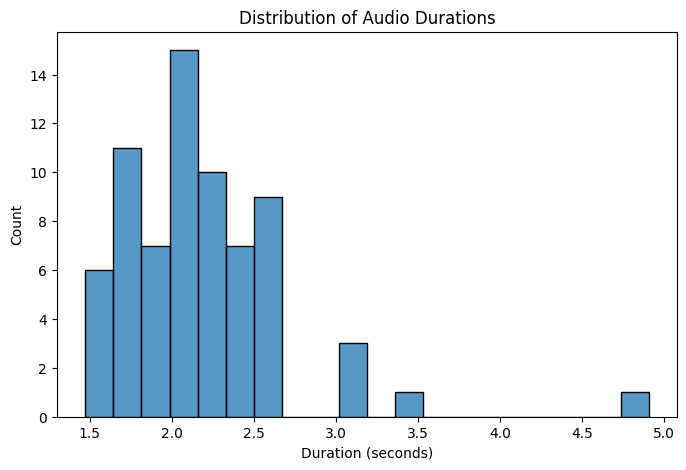

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

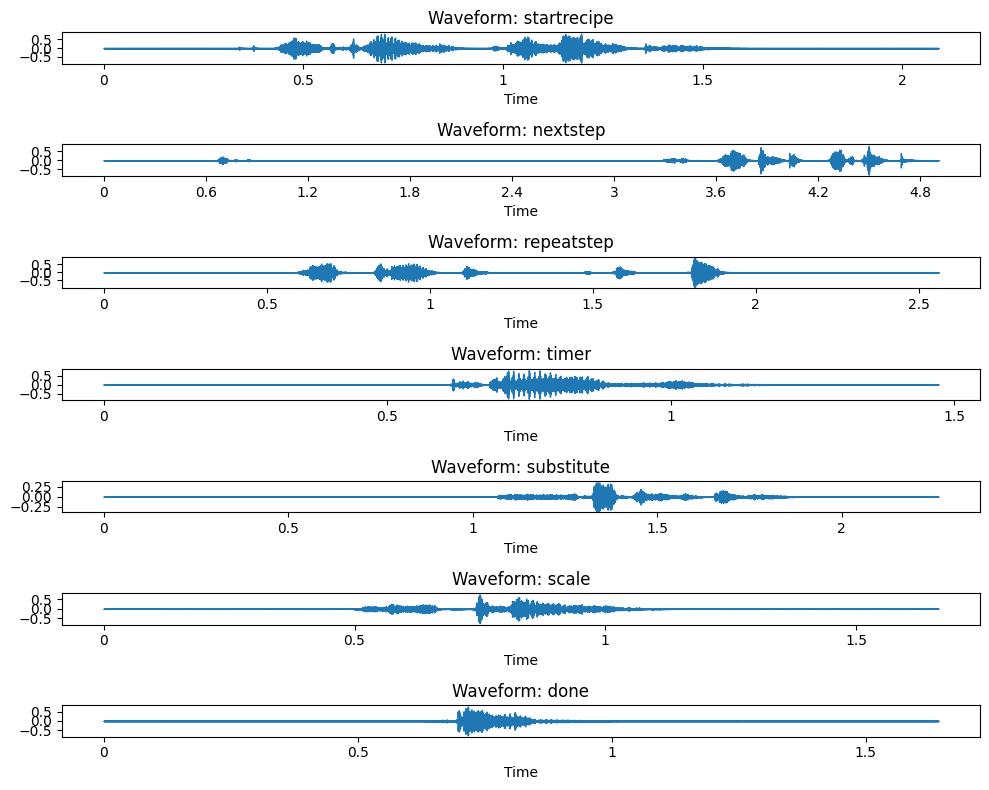

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import librosa.display

# Duration distribution
plt.figure(figsize=(8, 5))
sns.histplot(df["duration"], bins=20)
plt.title("Distribution of Audio Durations")
plt.xlabel("Duration (seconds)")
plt.ylabel("Count")
plt.savefig("duration_distribution.png")
plt.show()
files.download("duration_distribution.png")

# Sample waveform for one file per class
label_map = {0: "startrecipe", 1: "nextstep", 2: "repeatstep", 3: "timer",
             4: "substitute", 5: "scale", 6: "done"}
labels = df["label"].unique()
plt.figure(figsize=(10, 8))
for i, label in enumerate(labels):
    audio_path = df[df["label"] == label]["path"].iloc[0]
    y, sr = librosa.load(audio_path)
    plt.subplot(len(labels), 1, i + 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform: {label_map[label]}")
plt.tight_layout()
plt.savefig("sample_waveforms.png")
plt.show()
files.download("sample_waveforms.png")

Purpose: Visualizes audio length variability and signal characteristics.

3. Model Performance Visualization
- Goal: Plot accuracy/F1 trends and final fold results to show training dynamics.

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# Training data (accuracy and F1 per epoch for each fold)
fold_metrics = {
    1: {
        "accuracy": [0.142857, 0.142857, 0.142857, 0.142857, 0.142857, 0.142857, 0.142857, 0.142857, 0.142857, 0.142857, 0.142857, 0.142857, 0.142857, 0.142857, 0.142857, 0.142857, 0.142857, 0.142857, 0.142857, 0.142857],
        "f1": [0.035714, 0.035714, 0.035714, 0.035714, 0.035714, 0.035714, 0.035714, 0.035714, 0.035714, 0.063492, 0.035714, 0.035714, 0.035714, 0.035714, 0.035714, 0.035714, 0.035714, 0.035714, 0.035714, 0.035714]
    },
    2: {
        "accuracy": [0.142857, 0.357143, 0.285714, 0.142857, 0.214286, 0.285714, 0.285714, 0.357143, 0.428571, 0.357143, 0.357143, 0.428571, 0.571429, 0.785714, 0.785714, 0.785714, 0.785714, 0.785714, 0.785714, 0.785714],
        "f1": [0.035714, 0.238095, 0.190476, 0.142857, 0.130952, 0.170068, 0.170068, 0.319048, 0.319048, 0.290043, 0.238095, 0.342857, 0.480952, 0.733333, 0.733333, 0.733333, 0.733333, 0.733333, 0.733333, 0.733333]
    },
    3: {
        "accuracy": [0.142857, 0.071429, 0.142857, 0.071429, 0.071429, 0.071429, 0.142857, 0.214286, 0.214286, 0.285714, 0.357143, 0.285714, 0.214286, 0.428571, 0.500000, 0.428571, 0.428571, 0.428571, 0.428571, 0.428571],
        "f1": [0.038095, 0.035714, 0.095238, 0.028571, 0.023810, 0.023810, 0.047619, 0.099567, 0.167800, 0.246032, 0.295238, 0.246032, 0.174603, 0.362585, 0.511905, 0.366667, 0.397959, 0.414286, 0.414286, 0.414286]
    },
    4: {
        "accuracy": [0.214286, 0.214286, 0.357143, 0.142857, 0.285714, 0.142857, 0.285714, 0.357143, 0.642857, 0.500000, 0.500000, 0.642857, 0.642857, 0.500000, 0.642857, 0.571429, 0.571429, 0.571429, 0.571429, 0.571429],
        "f1": [0.133333, 0.128571, 0.223810, 0.166667, 0.200000, 0.152381, 0.302721, 0.338095, 0.600680, 0.371429, 0.390476, 0.590476, 0.571429, 0.471429, 0.571429, 0.514286, 0.514286, 0.514286, 0.514286, 0.514286]
    },
    5: {
        "accuracy": [0.214286, 0.142857, 0.142857, 0.142857, 0.142857, 0.142857, 0.142857, 0.142857, 0.142857, 0.142857, 0.142857, 0.142857, 0.142857, 0.142857, 0.142857, 0.142857, 0.142857, 0.142857, 0.142857, 0.142857],
        "f1": [0.101099, 0.047619, 0.035714, 0.035714, 0.035714, 0.035714, 0.035714, 0.035714, 0.035714, 0.035714, 0.035714, 0.035714, 0.035714, 0.035714, 0.035714, 0.035714, 0.040816, 0.043956, 0.051948, 0.051948]
    }
}

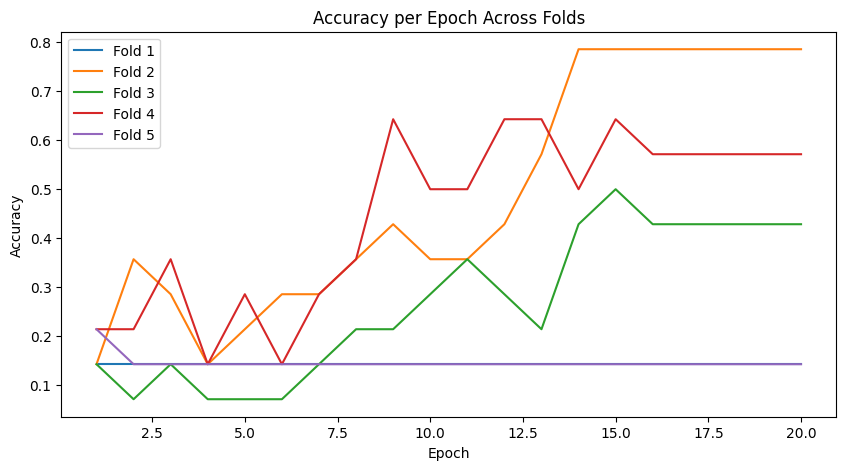

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
# Plot accuracy per fold
plt.figure(figsize=(10, 5))
for fold in fold_metrics:
    plt.plot(range(1, 21), fold_metrics[fold]["accuracy"], label=f"Fold {fold}")
plt.title("Accuracy per Epoch Across Folds")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("accuracy_per_fold.png")
plt.show()
files.download("accuracy_per_fold.png")

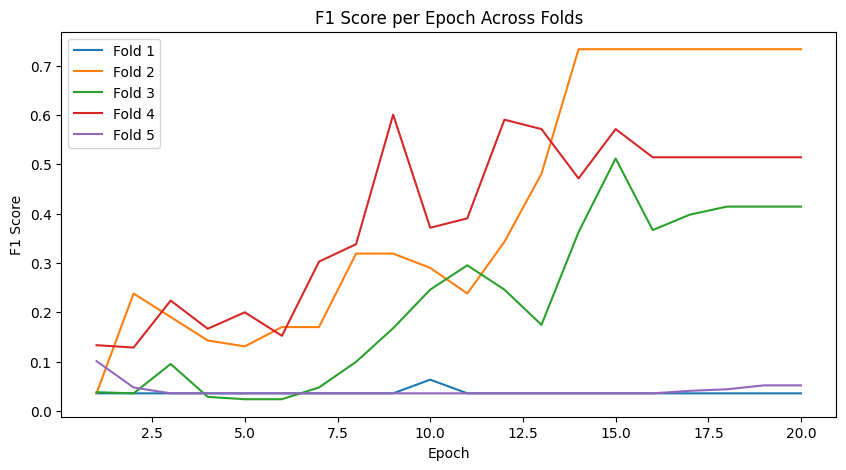

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
# Plot F1 score per fold
plt.figure(figsize=(10, 5))
for fold in fold_metrics:
    plt.plot(range(1, 21), fold_metrics[fold]["f1"], label=f"Fold {fold}")
plt.title("F1 Score per Epoch Across Folds")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()
plt.savefig("f1_per_fold.png")
plt.show()
files.download("f1_per_fold.png")

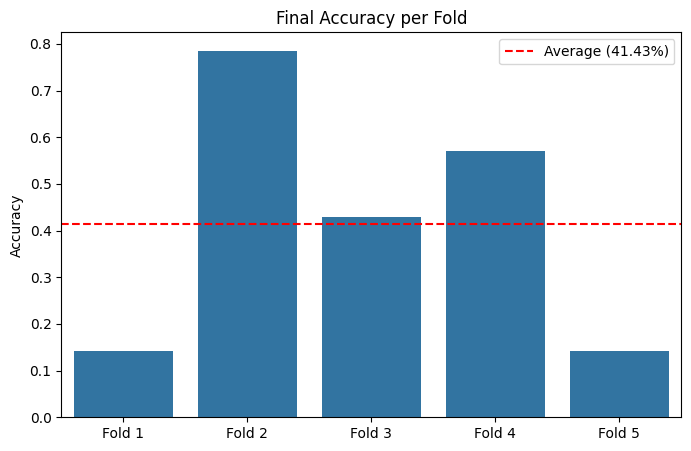

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
# Bar plot for final fold results
final_results = {
    "Fold 1": 0.142857, "Fold 2": 0.785714, "Fold 3": 0.428571,
    "Fold 4": 0.571429, "Fold 5": 0.142857
}
average_accuracy = sum(final_results.values()) / len(final_results)  # 0.4179
plt.figure(figsize=(8, 5))
sns.barplot(x=list(final_results.keys()), y=list(final_results.values()))
plt.title("Final Accuracy per Fold")
plt.ylabel("Accuracy")
plt.axhline(y=average_accuracy, color="r", linestyle="--", label=f"Average ({average_accuracy:.2%})")
plt.legend()
plt.savefig("final_accuracy_bar.png")
plt.show()
files.download("final_accuracy_bar.png")

Purpose: Highlights model learning and fold variability.